# Import packages {-}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import newaxis, fill_diagonal, sum, sqrt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

Below the provided functions for distance, LJ potential and gradient of the potential are defined. 

In [2]:
#experimental values for Argon atoms
epsilon = 0.997
sigma = 3.401

#euclidean distance function
def distance(points):
    displacement = points[:, newaxis] - points[newaxis, :]
    return sqrt(sum(displacement*displacement, axis=-1))

#potential function
def V(points):
    # points: (N,3)-array of (x,y,z) coordinates for N points
    dist = distance(points)

    # Fill diagonal with 1, so we don't divide by zero
    fill_diagonal(dist, 1)

    # dimensionless reciprocal distance
    f = sigma/dist

    # calculate the interatomic potentials
    pot = 4*epsilon*(f**12 - f**6)

    # Undo any diagonal terms (the particles don't interact with themselves)
    fill_diagonal(pot, 0)

    return sum(pot)/2


#gradient of potential function
def gradV(X):
    d = X[:, newaxis] - X[newaxis, :]
    r = sqrt(sum(d*d, axis=-1))

    fill_diagonal(r, 1)

    T = 6*(sigma**6)*(r**-7)-12*(sigma**12)*(r**-13)
    # (N,N)−matrix of r−derivatives
    # Using the chain rule , we turn the (N,N)−matrix of r−derivatives into
    # the (N,3)−array of derivatives to Cartesian coordinate: the gradient.
    # (Automatically sets diagonal to (0,0,0) = X[ i]−X[ i ])
    u = d/r[:, :, newaxis]
    # u is (N,N,3)−array of unit vectors in direction of X[ i ]−X[ j ]
    return 4*epsilon*sum(T[:, :, newaxis]*u, axis=1)

# Question a {-}

Below the Lennard-Jones potential for two particles for x in the range 3 to 11 is computed and plotted.

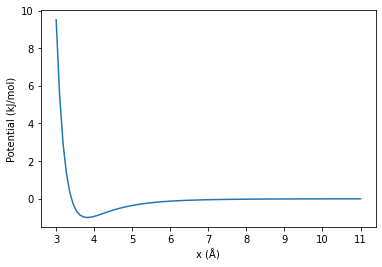

In [3]:
#plot LJ for 2 particles
LJ_2 = lambda x: V(np.array([[x,0,0],[0,0,0]]))

xs = np.linspace(3,11,90)
pots_2 = [LJ_2(x) for x in xs]
plt.plot(xs,pots_2,'-')
plt.xlabel('x (Å)')
plt.ylabel('Potential (kJ/mol)')
plt.show()

Below the Lennard-Jones potential for four particles again for x in the range 3 to 11 is computed and plotted.

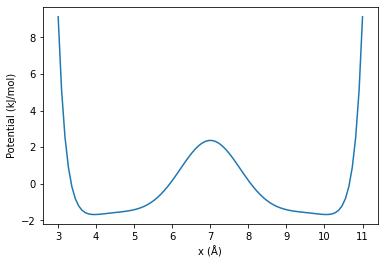

In [4]:
#plot LJ for 4 particles
LJ_4 = lambda x: V(np.array([[x,0,0],[0,0,0],[14,0,0],[7,3.2,0]]))

pots_4 = [LJ_4(x) for x in xs]
plt.plot(xs,pots_4,'-')
plt.xlabel('x (Å)')
plt.ylabel('Potential (kJ/mol)')
plt.show()

# Question b {-}

Below a bisection root finding function is defined to find the zero of a function in a given search bracket.

In [5]:
def bisection_root(f, a,b, tol=1e-13):
    fa, fb = f(a), f(b)
    assert(np.sign(fa) != np.sign(fb)) #make sure the bracket [a,b] is valid
    fx = fa
    n_calls = 2
    
    #run until f(x) is close enough to 0
    while abs(fx) > tol:
        n_calls += 1 #track how many times the function is called
        x = a+(b-a)/2 #find midpoint
        fx = f(x) #potential at midpoint
        if np.sign(fa) == np.sign(fx): #shrink bracket based on sign
            a, fa = x, fx 
        else:
            b = x
            
    return x, n_calls

Below the bisection root finding function is used to find the zero of the LJ-potential between two argon atoms as a function of interatomic distance along with the number of times the function is called before convergence. The initial search bracket is [2,6].

In [6]:
x, n_calls = bisection_root(LJ_2, 2, 6)
print('The zero of the LJ-potential as a function of interatomic distance is '+str(round(x, 4))+' which is indeed the value of sigma.')
print('The potential function was called '+str(n_calls)+' times.')

The zero of the LJ-potential as a function of interatomic distance is 3.401 which is indeed the value of sigma.
The potential function was called 48 times.


# Question c {-}
Below a Newton-Rhapson solver is written assuming that a call to the derivative function has the same cost as a call to the potential function.

In [7]:
def newton_root(f, df, x0, tol=1e-12):
    x = x0
    fx, dfx = f(x), df(x)
    n_calls = 0
    while abs(fx) > tol:
        assert(dfx != 0) #make sure not to divide by 0
        x = x - fx/dfx
        fx, dfx = f(x), df(x)
        n_calls += 2 #functions are called twice per iteration
    return x, n_calls+2

Below the Newton-Rhapson solver function is tested for x_0 = 2.

In [8]:
f = LJ_2
df = lambda x: 4*0.997*((6*3.401**6/x**7)-(12*3.401**12/x**13)) #derivate of pair-potential as function of distance
x, n_calls = newton_root(f, df, 2)

print('The zero of the LJ-potential as a function of interatomic distance is '+str(x.round(4))+' which is indeed the value of sigma.')
print('The potential/ derivative function was called '+str(n_calls)+' times.')

The zero of the LJ-potential as a function of interatomic distance is 3.401 which is indeed the value of sigma.
The potential/ derivative function was called 26 times.


# Question d {-}
Below a hybrid method combining Newton-Rhapson and bisection is written. 

In [9]:
def newton_bisection_hybrid(f, df, x0, a, b, tolerance=1e-13):
    x = x0
    fa, fb, fx = f(a), f(b), f(x)
    assert(np.sign(fa) != np.sign(fb))
    n_calls = 3
    
    while abs(fx) > tolerance:
        
        #compute tangent of approximate root
        dfx = df(x)
        n_calls += 1
        
        #make sure tangent is not 0 to avoid divide by 0
        if dfx != 0:  
            # compute newton-rhapson approximate root
            x = x - fx/dfx

            #make sure new approximate root lies within between a and b
            if x > a and x < b:

                #compute function value of new approximate root to shrink the interval
                fx = f(x)
                n_calls += 1

                #shrink interval based on sign of f(x)                    
                if np.sign(fx) == np.sign(fa):
                    a, fa = x, fx 
                else:
                    b = x
        
            #if the new x does not fall within a and b revert to bisection
            else:
                if np.sign(fx) == np.sign(fa):
                    a = x
                else:
                    b = x
                x = a+(b-a)/2
                fx = f(x)
                n_calls += 1
                
        #if the tangent is 0 revert to bisection
        else:
            if np.sign(fx) == np.sign(fa):
                a = x
            else:
                b = x
            x = a+(b-a)/2
            fx = f(x)
            n_calls += 1
            
    return x, n_calls

Below the hydrid solver is tested for x0 = 2. Same tolerance and bracket as above. 

In [10]:
x, n_calls = newton_bisection_hybrid(f, df, 2, 2, 6)

print('The zero of the LJ-potential as a function of interatomic distance is '+str(x.round(4))+' which is indeed the value of sigma.')
print('The potential/ derivative function was called '+str(n_calls)+' times.')

The zero of the LJ-potential as a function of interatomic distance is 3.401 which is indeed the value of sigma.
The potential/ derivative function was called 27 times.


# Question e {-}
Below the gradient of the 2-particle system at the arbitrary choice of x=3 is printed.

In [11]:
#print gradient for arbitrary choice of x = 3
LJgrad = gradV(np.array([[3,0,0],[0,0,0]]))
print('Gradient of 2-particle system at x=3:')
print(LJgrad)

Gradient of 2-particle system at x=3:
[[-54.9536532   0.          0.       ]
 [ 54.9536532   0.          0.       ]]


The reason why exactly two components of the gradient are non-zero is that the two particles are only separated in the x-direction. The reason why the two non-zero terms are equal size and opposite sign is that the two particle act on each other with the same magnitude of force but of course in opposite directions. 

Below the non-zero component of the derivative for x in [3,10] is plotted along with the potential in the same range.

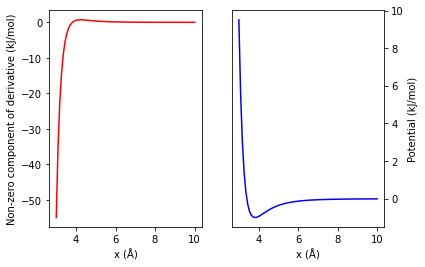

In [12]:
#define function that returns the non-zero component of the derivative of a pair as a function of x
grad_2 = lambda x: gradV(np.array([[x,0,0],[0,0,0]]))[0,0]

#plot the non-zero term of the derivative
xs = np.linspace(3,10,80)
fxs = [grad_2(x) for x in xs]
plt.subplot(1, 2, 1)
plt.plot(xs, fxs, 'r')
plt.xlabel('x (Å)')
plt.ylabel('Non-zero component of derivative (kJ/mol)')

#plot the potential for comparison
pot = [LJ_2(x) for x in xs]
ax = plt.subplot(1, 2, 2)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.plot(xs, pot, 'b')
plt.xlabel('x (Å)')
plt.ylabel('Potential (kJ/mol)')
plt.show()

The zero of the derivative and the minimum of the potential are at the same value of x. 

Below the gradient for the 4-particle system is printed at one of the potential minima.

In [13]:
xmin = np.linspace(3,11,90)[np.argmin(pots_4)] #find minimum of potential
mingrad = gradV(np.array([[xmin,0,0],[0,0,0],[14,0,0],[7,3.2,0]]))
print('Gradient of the 4-particle system at minimum:')
print(mingrad)

Gradient of the 4-particle system at minimum:
[[ 0.07262673 -0.4860128   0.        ]
 [-0.55471738 -0.00947811  0.        ]
 [ 0.02474715 -0.00947811  0.        ]
 [ 0.45734351  0.50496902  0.        ]]


The reason why the gradient of the 4-particle potential at the potential minimum is non-zero is that the potential is only minimized in one direction. 

# Question f {-}
Below a linesearch function is defined.

In [14]:
def linesearch(F, x0, d, alpha_max):
    def line_func(alpha): #fine line segment 
        Fvec = F(x0+alpha*d).reshape(-1,1) #reshape to a column vector
        drow = d.reshape(1,-1) #reshape to a row vector
        return np.dot(drow, Fvec)    
    
    x, n_calls = bisection_root(line_func, 0, alpha_max)
    
    return x, n_calls

Below the linesearch function is tested using the conditions specified for question f. 

In [15]:
x0 = np.array([[4,0,0],[0,0,0],[14,0,0],[7,3.2,0]])
d = - gradV(x0)
x, n_calls = linesearch(gradV, x0, d, 1)
print('The minimum along the line segment is alpha = '+str(x)+'.')
print('The gradient function was called '+str(n_calls)+' times.')

The minimum along the line segment is alpha = 0.4517070518421633.
The gradient function was called 45 times.


# Question g {-}
Below a golden section search function is defined to find the minimum of a function on a unimodal interval. 

In [16]:
#define golden section function
def golden_section_min(f, a, b, tol=1e-3):
    tau = (np.sqrt(5)-1)/2
    x1 = a+(1-tau)*(b-a)
    f1 = f(x1)
    x2 = a+tau*(b-a)
    f2 = f(x2)
    n_calls = 2
    
    while b-a > tol:
        if f1 > f2:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a+tau*(b-a)
            f2 = f(x2)
        else:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a+(1-tau)*(b-a)
            f1 = f(x1)
            
        n_calls +=1
        
    return (x1+x2)/2, n_calls

Below the golden section function is used to find the value of alpha that minmizes the potential. 

In [17]:
#use function to find alpha for min
alpha_func = lambda alpha: V(x0+alpha*d)
x_opt, n_calls = golden_section_min(alpha_func, 0, 1)
print('The alpha that minimizes the potential is alpha = '+str(x_opt)+'.')
print('The potential function was called '+str(n_calls)+' times.')

The alpha that minimizes the potential is alpha = 0.4516693913190848.
The potential function was called 17 times.


Below the golden section function is used to find the interatomic distance r_0 that minimizes the potential.

In [18]:
#use function to find optimal distance
pot_from_dist = lambda r: V(np.array([[0,0,0],[r,0,0]]))
r_0, n_calls = golden_section_min(pot_from_dist, 2, 6)
print('The distance that minimizes the potential is r_0 = '+str(r_0)+'.')
print('The potential function was called '+str(n_calls)+' times.')

The distance that minimizes the potential is r_0 = 3.8172876299217666.
The potential function was called 20 times.


# Question h {-}
Below a BFGS function is defined using an approximation for the inverse Hessian. 

In [19]:
#define BFGS function using inverse Hessian approximation
def BFGS(f, gradf, x, tol=1e-6, max_iter=20000):
    x = np.copy(x)
    B = np.identity(len(x)) #initialize approximate inverse Hessian
    gradf0 = gradf(x)
    n_calls = 0
    while np.linalg.norm(gradf0) > tol:
        s = -B@gradf0 #change in x along steepest descent
        x += s #apply change to x
        gradf1 = gradf(x) #compute gradient for new x
        y = gradf1-gradf0 #difference in gradients
        B += (np.outer(s,s)/np.dot(s,y))-((B@np.outer(y,y)@B)/np.dot(y,B@y)) #update approximate inverse Hessian
        #s and y are switched above compared to the BFGS algorithm in the book since the inverse Hessian is used
        n_calls += 1
        gradf0 = np.copy(gradf1) #save gradient for x for next iteration
        
        if n_calls <= max_iter:
            converged = True
        else:
            converged = False
            break

    
    return x, n_calls+1, converged

Below the provided flatten functions are used to flatten the potential function, the gradient function and the distance function. 

In [20]:
#flatten potential functions
def flatten_function(f):
    return lambda x: f(x.reshape(-1, 3))

def flatten_gradient(f):
    return lambda x: f(x.reshape(-1, 3)).reshape(-1)

flat_V     = flatten_function(V)
flat_gradV = flatten_gradient(gradV)
flat_dist_func = flatten_function(distance)

Below the BFGS function is used to find the minimum of the two-particle system using XStart2 as starting positions. From the minimizing positions the flattened distance function is used to find the interatomic distance between the particles at the minimizing positions. 

In [21]:
#load data and use BFGS
datalist = np.load('ArStart.npz')
Xstart2 = datalist['Xstart2']

x, n_calls, conv= BFGS(flat_V, flat_gradV, Xstart2)
print('Optimal distance according to BFGS is r_0 = '+str(flat_dist_func(x)[1,0])+' which is the same r_0 as above.')
print('The gradient function was called '+str(n_calls)+' times.')
print('The function converged: '+str(conv)+'.')

Optimal distance according to BFGS is r_0 = 3.817493425601058 which is the same r_0 as above.
The gradient function was called 7 times.
The function converged: True.


# Question i {-}
Below the BFGS function is applied to all starting positions defined in ArStarts from N=2 to N=9. The number og van der Waals (vdW) bonds found, the number of times the gradient function was called and whether or not the BFGS function converged for each N is shown in the table below.

In [22]:
datas = [datalist[list(datalist.keys())[i]] for i in range(8)]
convs = []
xs = []
vdW_bonds = []
calls = []

for data in datas:
    x, n_calls, conv = BFGS(flat_V, flat_gradV, data)
    xs.append(x)
    convs.append(str(conv)) #append str for pandas to print bool and not int
    D = (flat_dist_func(x).reshape(1,-1))[0]
    vdW_bonds.append(np.sum(abs(D - r_0)/r_0 <=0.01)/2) #number of distances within 1% of optimum r_0
    calls.append(n_calls)

Ns = np.linspace(2,9,8)
df = pd.DataFrame(np.array([Ns,vdW_bonds, convs, calls]).T, columns=['N', 'vdW bonds', 'Converged', 'Calls to function'])
df

,N,vdW bonds,Converged,Calls to function
0,2.0,1.0,True,7
1,3.0,3.0,True,72
2,4.0,0.0,True,45
3,5.0,0.0,False,20002
4,6.0,0.0,True,14
5,7.0,0.0,True,22
6,8.0,0.0,True,36
7,9.0,0.0,False,20002


The BFGS function is able to converge for most N but only finds vdW bonds of optimal length for N=2 and N=3. For N=5 the function does not converged within the max number of iterations. This might be due to how the starting positions in ArStart are defined, since the function is able to converge for higher N than 5. 

Below the minimizing positions for N=3 are visualized in 3D.

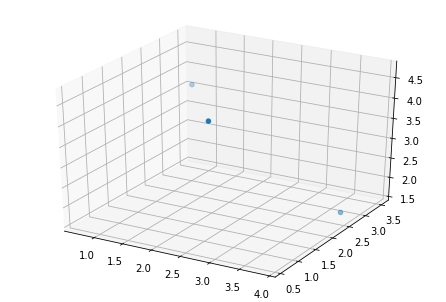

In [23]:
#plot for N=3
Xstart3 = datalist['Xstart3']
x3, n_calls3, converged3 = BFGS(flat_V, flat_gradV, Xstart3)
x3 = x3.reshape(3,3)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x3[:,0], x3[:,1], x3[:,2])

Below the minimizing positions for N=8 are visualized in 3D. N=8 was the highest N to converge using the BFGS function. 

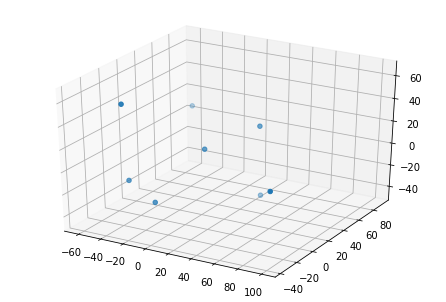

In [24]:
#plot N=8 which is highest to converge
Xstart8 = datalist['Xstart8']
x8, n_calls8, converged8 = BFGS(flat_V, flat_gradV, Xstart8)
x8 = x8.reshape(8,3)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x8[:,0], x8[:,1], x8[:,2])

# Question j {-}
Below a line-search using the golden section function from question g is added to the BFGS function. 
The modified BFGS function is then applied to the starting positions from ArStart for  N=2 to N=9 and N=20. 

In [25]:
#define BFGS function combined with golden section line search
def BFGS_mod(f, gradf, x, tol=1e-6, max_iter=20000):
    x = np.copy(x)
    B = np.identity(len(x))
    gradf0 = gradf(x)
    n_calls = 1
    n_iter = 0
    while np.linalg.norm(gradf0) > tol:
        n_iter += 1
        s = -B@gradf0
        alpha_func = lambda alpha: f(x+alpha*s) #define function to find optimal alpha
        alpha_opt, n = golden_section_min(alpha_func, -1, 1) #find alpha that minimizes potential
        n_calls += n #function is called n times in golden section search
        x += s*alpha_opt #multiply optimal alpha to change in x
        gradf1 = gradf(x)
        n_calls += 1
        y = gradf1-gradf0
        B += (np.outer(s,s)/np.dot(s,y))-((B@np.outer(y,y)@B)/np.dot(y,B@y))
        gradf0 = np.copy(gradf1)
        
        if n_iter <= max_iter:
            converged = True
        else:
            converged = False
            break

    
    return x, n_calls, converged, n_iter

In [26]:
#load data and use modified BFGS
datas = [datalist[list(datalist.keys())[i]] for i in range(8)]
datas.append(datalist['Xstart20'])
convs = []
xs = []
vdW_bonds = []
calls = []
iters = []
for data in datas:
    x, n_calls, conv, n_iter = BFGS_mod(flat_V, flat_gradV, data)
    xs.append(x)
    convs.append(str(conv))
    D = (flat_dist_func(x).reshape(1,-1))[0]
    vdW_bonds.append(np.sum(abs(D - r_0)/r_0 <=0.01)/2)
    calls.append(n_calls)
    iters.append(n_iter)

Ns = np.linspace(2,9,8)
Ns = np.append(Ns,20)
df = pd.DataFrame(np.array([Ns,vdW_bonds, convs, calls, iters]).T, columns=['N', 'vdW bonds', 'Converged', 'Calls to functions', 'BFGS Iterations'])
df

,N,vdW bonds,Converged,Calls to functions,BFGS Iterations
0,2.0,1.0,True,39,2
1,3.0,3.0,True,267,14
2,4.0,6.0,True,666,35
3,5.0,9.0,True,246450,12971
4,6.0,12.0,True,96312,5069
5,7.0,8.0,False,380020,20001
6,8.0,18.0,True,10907,574
7,9.0,20.0,True,5207,274
8,20.0,14.0,True,238280,12541


Using the modified BFGS function all N were able to converge, except for N=7 which might be due to how the starting positions are defined just as for N=5 in question i. The number of vdW bonds found is much better for the modified BFGS than for the "bare" BFGS. The number of calls to the potential and gradient functions (again assuming they have the same cost) is smaller using the modified BFGS for N<=5, however for larger N the modified BFGS uses a lot more function calls. 

# Question k {-}
Below the metaheuristic optimization algorithm Simulated Annealing is implemented. 

In [27]:
#define simulated annealing function
def simulated_annealing(f,x0,temp,tol=1e-5,converged=False):
    f0 = f(x0)
    x1 = x0 + np.random.uniform(-0.01,0.01,len(x0))
    f_diff = f(x1) - f0
    
    if abs(f_diff) < tol:
        converged = True
    
    metropolis = np.exp(-f_diff*1e4/temp)
    
    if metropolis > np.random.uniform(0,1):
        return x1, converged
    else:
        return x0, converged

Below the simulated annealing function is applied to the starting positions for N=5, N=9 and N=20. The minimizing positions are plotted in 3D and the number of vdW bonds found is printed. 

Number of vdW bonds for N = 5: 9
Number of vdW bonds for N = 9: 19
Number of vdW bonds for N = 20: 32


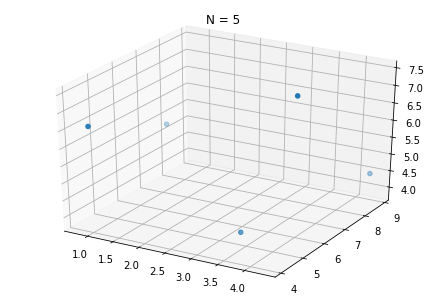

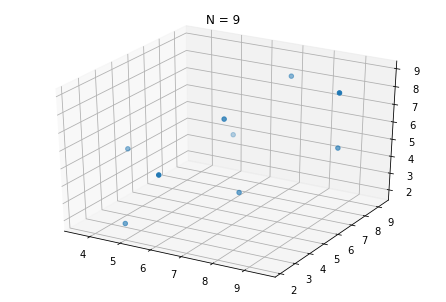

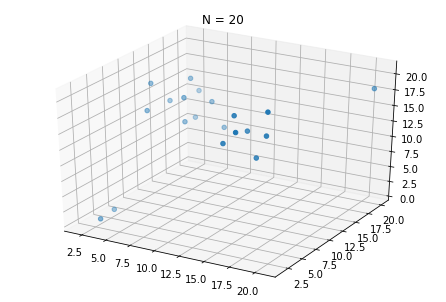

In [28]:
#use simulated annealing for each of the three Ns
temps = np.linspace(0.01, 100, 100)[::-1] #100 temperatures between 100 and 0.01
datas = [datalist['Xstart5'],datalist['Xstart9'],datalist['Xstart20']]
pots = []
ns = []

for data in datas:
    pot = [] #list for potential values
    n = [] #list for number of function calls
    n_calls = 0
    
    for temp in temps:
        for i in range(1000):
            data, converged = simulated_annealing(flat_V,data,temp)
            n_calls += 2 #simulated annealing calls function twice
            if converged:
                break
        pot.append(flat_V(data)) #append potential for each iteration
        n_calls += 1 
        n.append(n_calls) #append accumulated number of function calls
    pots.append(pot)
    ns.append(n)
    
    N = int(len(data)/3)
    D = flat_dist_func(data)
    bonds = (np.sum(abs(D - r_0)/r_0 <=0.01)/2)
    print('Number of vdW bonds for N = '+str(N)+': '+str(int(bonds)))
    
    #plot positions
    fig = plt.figure()
    ax = Axes3D(fig)
    x = data.reshape(N,3)
    ax.scatter(x[:,0], x[:,1], x[:,2])
    ax.set_title('N = '+str(N))

The simulated annealing was able to find the same number of vdW bonds for N=5 and N=9 as for the modified BFGS function. The simulated annealing function was also able to converge for N=20 and to find more vdW bonds than the modified BFGS function was able to find. 

Below the potential at each iteration step for the simulated annealing function is plotted. 

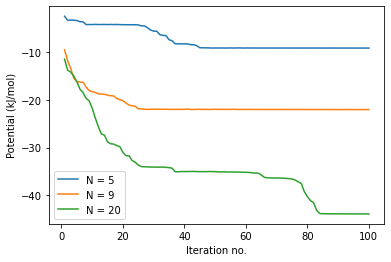

In [29]:
#plot potential as function of iteration no.
plt.figure()
xs = np.linspace(1,len(temps),len(temps))
plt.plot(xs, pots[0], label='N = 5')
plt.plot(xs, pots[1], label='N = 9')
plt.plot(xs, pots[2], label='N = 20')
plt.legend()
plt.xlabel('Iteration no.')
plt.ylabel('Potential (kJ/mol)')
plt.show()

Below the potential as a function of accumulated number of calls to the potential function is plotted. 

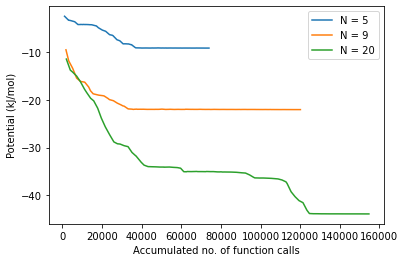

In [30]:
#plot potential as a function of accumulated number of function calls
plt.figure()
plt.plot(ns[0], pots[0], label='N = 5')
plt.plot(ns[1], pots[1], label='N = 9')
plt.plot(ns[2], pots[2], label='N = 20')
plt.legend()
plt.xlabel('Accumulated no. of function calls')
plt.ylabel('Potential (kJ/mol)')
plt.show()